In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobi_logtools as glt

Set path to log files

In [4]:
name = "logs"
PATH = f".\experiments\{name}"

Parse log files

In [5]:
result = glt.parse(PATH+"\*.log")
summary = result.summary()


Get node log

In [6]:

nl = result.progress("nodelog")
print(nl[~nl['Incumbent'].isna()])
nl.head()

Empty DataFrame
Columns: [CurrentNode, RemainingNodes, Obj, Depth, IntInf, Incumbent, BestBd, Gap, ItPerNode, Time, Pruned, LogFilePath, LogNumber, Seed, Version]
Index: []


,CurrentNode,RemainingNodes,Obj,Depth,IntInf,Incumbent,BestBd,Gap,ItPerNode,Time,Pruned,LogFilePath,LogNumber,Seed,Version
0,0,0.0,0.04362,0.0,18493.0,None,0.04362,None,NaN,247.0,NaN,.\experiments\logs\reactor_r1_c1_no_mc.log,1,0,11.0.2
1,0,0.0,0.04362,0.0,18233.0,None,0.04362,None,NaN,380.0,NaN,.\experiments\logs\reactor_r1_c1_no_mc.log,1,0,11.0.2
2,0,0.0,0.04362,0.0,18620.0,None,0.04362,None,NaN,489.0,NaN,.\experiments\logs\reactor_r1_c1_no_mc.log,1,0,11.0.2
3,0,0.0,0.04362,0.0,18587.0,None,0.04362,None,NaN,680.0,NaN,.\experiments\logs\reactor_r1_c1_no_mc.log,1,0,11.0.2
4,0,0.0,0.04362,0.0,18653.0,None,0.04362,None,NaN,1266.0,NaN,.\experiments\logs\reactor_r1_c1_no_mc.log,1,0,11.0.2


Add columns to node log to include experiment Rep and Config

In [8]:
regex_pattern = r'.*_r(\d+)_c(\d+)_.*\.log'
nl[['Repetition', 'Config']] = nl['LogFilePath'].str.extract(regex_pattern)
nl.head()

,CurrentNode,RemainingNodes,Obj,Depth,IntInf,Incumbent,BestBd,Gap,ItPerNode,Time,Pruned,LogFilePath,LogNumber,Seed,Version,Repetition,Config
0,0,0.0,0.04362,0.0,18493.0,None,0.04362,None,NaN,247.0,NaN,.\experiments\logs\reactor_r1_c1_no_mc.log,1,0,11.0.2,1,1
1,0,0.0,0.04362,0.0,18233.0,None,0.04362,None,NaN,380.0,NaN,.\experiments\logs\reactor_r1_c1_no_mc.log,1,0,11.0.2,1,1
2,0,0.0,0.04362,0.0,18620.0,None,0.04362,None,NaN,489.0,NaN,.\experiments\logs\reactor_r1_c1_no_mc.log,1,0,11.0.2,1,1
3,0,0.0,0.04362,0.0,18587.0,None,0.04362,None,NaN,680.0,NaN,.\experiments\logs\reactor_r1_c1_no_mc.log,1,0,11.0.2,1,1
4,0,0.0,0.04362,0.0,18653.0,None,0.04362,None,NaN,1266.0,NaN,.\experiments\logs\reactor_r1_c1_no_mc.log,1,0,11.0.2,1,1


Average metrics over Rep and Config

In [15]:
import pandas as pd

# Ensure columns are numeric, converting non-numeric entries to NaN
for col in ['Time', 'CurrentNode', 'Gap', 'Incumbent']:
    nl[col] = pd.to_numeric(nl[col], errors='coerce')

# Define helper functions for individual column aggregations
def time_to_first_feasible(series):
    feasible_times = series.dropna()
    return feasible_times.min() if not feasible_times.empty else np.nan

def solutions(series):
    feasible_times = series.dropna()
    return feasible_times.min() if not feasible_times.empty else np.nan

def final_value(series):
    valid_values = series.dropna()
    return valid_values.iloc[-1] if not valid_values.empty else np.nan

def unique_solutions(series):
    return series.dropna().nunique()

# Aggregate metrics per Config and Repetition
config_metrics = (
    nl.groupby(['Config', 'Repetition']).agg(
        Time_to_optimal=('Time', 'max'),
        Time_to_first_feasible=('Time', time_to_first_feasible),
        Nodes_explored=('CurrentNode', 'max'),
        Solutions_found=('Incumbent', unique_solutions),
        Final_gap=('Gap', final_value),
        Objective_value=('Incumbent', final_value)
    )
    .reset_index()
)

# Average the metrics over the two repetitions for each configuration
average_metrics = config_metrics.groupby('Config').mean(numeric_only=True).reset_index()

# Display the resulting DataFrame
average_metrics.columns = [
    'Config', 'Avg_Time_to_optimal', 'Avg_Time_to_first_feasible', 'Avg_Nodes_explored',
    'Avg_Solutions_found', 'Avg_Final_gap', 'Avg_Objective_value'
]

average_metrics


,Config,Avg_Time_to_optimal,Avg_Time_to_first_feasible,Avg_Nodes_explored,Avg_Solutions_found,Avg_Final_gap,Avg_Objective_value
0,1,43200.26,247.0,1786.0,0.0,NaN,NaN
1,3,49502.69,135.0,3410.0,0.0,NaN,NaN
2,4,43200.29,215.0,1383.0,0.0,NaN,NaN


Get MEAN and STD of Objective Bounds

In [16]:
grouped_nl = nl.groupby(['Config', 'Time']).agg({
    'Incumbent': ['mean', 'std'],
    'BestBd': ['mean', 'std'],
}).reset_index()

configs = grouped_nl['Config'].unique()
grouped_nl.head()

Config    Time Incumbent       BestBd    
                      mean std     mean std
0      1   247.0       NaN NaN  0.04362 NaN
1      1   380.0       NaN NaN  0.04362 NaN
2      1   489.0       NaN NaN  0.04362 NaN
3      1   680.0       NaN NaN  0.04362 NaN
4      1  1266.0       NaN NaN  0.04362 NaN

Update column names in grouped_nl dataframe

In [17]:
grouped_nl.columns = ['Config', 'Time', 'Incumbent_mean', 'Incumbent_std', 'BestBd_mean', 'BestBd_std']
grouped_nl.head()

,Config,Time,Incumbent_mean,Incumbent_std,BestBd_mean,BestBd_std
0,1,247.0,NaN,NaN,0.04362,NaN
1,1,380.0,NaN,NaN,0.04362,NaN
2,1,489.0,NaN,NaN,0.04362,NaN
3,1,680.0,NaN,NaN,0.04362,NaN
4,1,1266.0,NaN,NaN,0.04362,NaN


Define bounds + cuts configurations corresponding to experiments

In [18]:
combinations = {
    #'All': {'LN_I': 1, 'MHA_I': 1, 'MHA_D': 1, 'MHA_MC': 1},
    'No_MC': {'LN_I': 1, 'MHA_I': 1, 'MHA_D': 1, 'MHA_MC': 0}, #2
    #'I_only': {'LN_I': 1, 'MHA_I': 1, 'MHA_D': 0, 'MHA_MC': 0}, #3
    # 'LN_only': {'LN_I': 1, 'MHA_I': 0, 'MHA_D': 0, 'MHA_MC': 0},
    # 'Prop_MC': {'LN_I': 1, 'MHA_I': 0, 'MHA_D': 1, 'MHA_MC': 1},
    'LN_prop': {'LN_I': 1, 'MHA_I': 0, 'MHA_D': 1, 'MHA_MC': 0}, #6
    #'None': {'LN_I': 0, 'MHA_I': 0, 'MHA_D': 0, 'MHA_MC': 0},
    'All': {'LN_I': 1, 'MHA_I': 1, 'MHA_D': 1, 'MHA_MC': 1},
}


Plot Convergence of Objective Bounds

C:\Users\sian_\AppData\Local\Temp\ipykernel_93996\3228495308.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 42300)


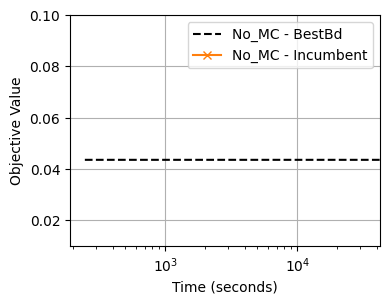

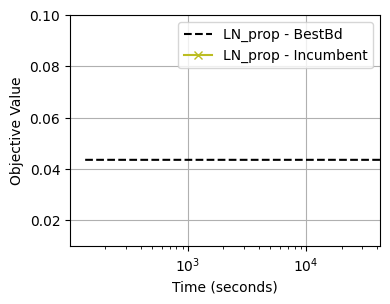

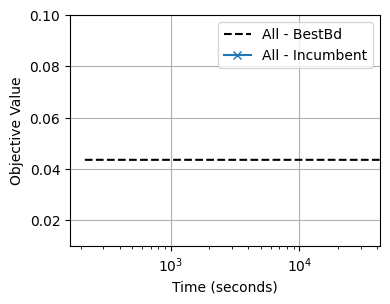

In [19]:

# Initialize the figure size
colors = plt.get_cmap('tab10', len(grouped_nl['Config'].unique()))
colours = ['tab:orange',  'tab:olive', 'tab:blue']

config_names = list(combinations.keys())

individ = False
if individ:
    grouped_nl = nl
    combi = grouped_nl[['Repetition', 'Config']].drop_duplicates()
    configs = combi.to_records(index=False).tolist()
    #combi = grouped_nl[['Config']].drop_duplicates()#grouped_nl[['Repetition', 'Config']].drop_duplicates()
    #configs = grouped_nl['Config'].unique()#combi.to_records(index=False).tolist()
else:
    # Find the global min and max values for both the x and y axes across all configurations
    x_min = 0#grouped_nl['Time'].min()
    x_max = 1e6 #grouped_nl['Time'].max()

    y_min = 1e-2 #min(grouped_nl['Incumbent_mean'].min(), grouped_nl['BestBd_mean'].min())
    y_max = 1e-1 #max(grouped_nl['Incumbent_mean'].max(), grouped_nl['BestBd_mean'].max())

# Plot each configuration using the same x and y axis limits
for i, config in enumerate(configs):
    plt.figure(i, figsize=(4, 3))
    print()

    # Plot Incumbent mean
    if not individ:
        color = colours[i]
        config_data = grouped_nl[grouped_nl['Config'] == config]
        plt.plot(config_data['Time'], config_data['BestBd_mean'], linestyle='--', label=f'{config_names[i]} - BestBd', color='k')
        
        plt.plot(config_data['Time'], config_data['Incumbent_mean'], 'x-', label=f'{config_names[i]} - Incumbent', color=color)
    else:
        config_data = grouped_nl[(grouped_nl['Config'] == config[-1]) & (grouped_nl['Repetition'] == config[0])]
        plt.plot(config_data['Time'], config_data['Incumbent'], 'x-', label=f'{config}_{i}')
        plt.plot(config_data['Time'], config_data['BestBd'], linestyle='--', label=f'{config}_{i}')

    # Set to log scale
    #plt.yscale('log')
    plt.xscale('log')

    # # Set the same x and y limits for all plots
    plt.xlim(0, 42300)
    plt.ylim(y_min, y_max)

    # Add labels
    plt.grid(True)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Objective Value')
    plt.legend()
    

     
